In [56]:
from os import listdir
from os.path import isfile, join
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import models
from keras import layers
import pickle as pk

In [16]:
# def data_gen(folder, images_num): 
#     datagen= ImageDataGenerator( shear_range = 0.1, zoom_range = 0.1, horizontal_flip = False)
#     p=[]
#     mypath=folder
#     onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
#     temp1 = np.empty(len(onlyfiles), dtype=object)
#     for n in range(0, len(onlyfiles)):
#         temp1=cv2.imread( join(mypath,onlyfiles[n]),0 )
#         p.append(temp1)
#     p=np.array(p)
#     temp=[]
#     for i in range(0,len(p)):
#         h=cv2.resize(p[i],(128,128))
#         temp.append(h)
#     p = np.array(temp)
#     i=0  
#     for batch in datagen.flow(p.reshape(len(p),128,128,1), batch_size = 1, save_to_dir =folder,  save_prefix ='aug', save_format ='jpg'): 
#         i += 1
#         if i > images_num: 
#             break

In [17]:
# data_gen('C:/Users/akash/Desktop/umpire out',500)
# data_gen('C:/Users/akash/Desktop/umpire six',121)
# data_gen('C:/Users/akash/Desktop/umpire wide',500)
# data_gen('C:/Users/akash/Desktop/umpire no ball',500)

In [18]:
def img_pre(location):
    temp=[]
    mypath=location
    onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
    temp1 = np.empty(len(onlyfiles), dtype=object)
    for n in range(0, len(onlyfiles)):
        temp1=cv2.imread( join(mypath,onlyfiles[n]),0 )
        temp.append(temp1)
    temp = np.array(temp)
    temp3 = []
    for i in range(0,len(temp)):
        temp2=cv2.resize(temp[i],(128,128))
        temp3.append(temp2)
    temp = np.array(temp3)
    temp4=[]
    temp5=[]
    for i in range(0,len(temp)):
#         temp4=cv2.Canny(temp[i],100,100)
        temp4 = cv2.Laplacian(temp[i],cv2.CV_8U)
        temp5.append(temp4)
    temp5=np.array(temp5)
    temp6=[]
    for i in range(0,len(temp)):  
        a=temp5[i].reshape(128*128,)
        temp6.append(a)
    temp = np.array(temp6)
    temp = temp.astype('float32')
    temp /= 255.0
    return temp

In [19]:
out = img_pre('C:/Users/akash/Desktop/umpire out')
six = img_pre('C:/Users/akash/Desktop/umpire six')
noball = img_pre('C:/Users/akash/Desktop/umpire no ball')
wide = img_pre('C:/Users/akash/Desktop/umpire wide')

In [20]:
six.shape

(656, 16384)

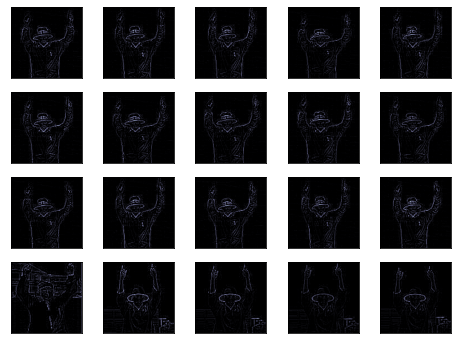

In [21]:
fig = plt.figure(figsize=(8, 6))
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(six[i].reshape(128,128), cmap=plt.cm.bone)

In [22]:
out.shape

(656, 16384)

In [23]:
def categorize(num,arr):
    a = [num]* len(arr)
    a= np.array(a)
    a=a.reshape(len(arr),1)
    arr=np.append(arr,a,axis=1)
    return arr

In [24]:
out= categorize(0,out)
six= categorize(1,six)
noball = categorize(2,noball)
wide = categorize(3,wide)

In [25]:
out.shape , six.shape , noball.shape , wide.shape

((656, 16385), (656, 16385), (656, 16385), (656, 16385))

In [26]:
umpire=np.concatenate((out,six,noball,wide))
umpire.shape
x=np.delete(umpire,-1,axis=1)
y=umpire[:,-1]

In [27]:
 x.shape, y.shape

((2624, 16384), (2624,))

In [28]:
x1=x
y1=y

In [29]:
y=pd.get_dummies(y)

In [30]:
y

,0.0,1.0,2.0,3.0
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
2619,0,0,0,1
2620,0,0,0,1
2621,0,0,0,1
2622,0,0,0,1


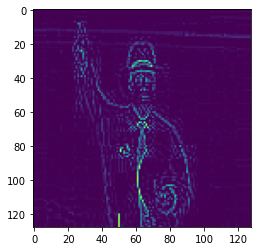

In [31]:
plt.imshow(x[190].reshape(128,128))

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_train.shape, y_train.shape

((2099, 16384), (2099, 4))

In [33]:
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.2, random_state=2)
x_train1.shape, y_train1.shape

((2099, 16384), (2099,))

In [78]:
nn=models.Sequential()
nn.add(layers.Dense(1000,activation="relu", input_shape=(128*128,)))
nn.add(layers.Dense(500,activation="relu"))
nn.add(layers.Dense(300,activation="relu"))
# nn.add(layers.Dropout(0.35))
nn.add(layers.Dense(4,activation="softmax"))

In [79]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              16385000  
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 300)               150300    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1204      
Total params: 17,037,004
Trainable params: 17,037,004
Non-trainable params: 0
_________________________________________________________________


In [80]:
nn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
filepath = 'C:/Users/akash/Desktop/best_model_SM_crick.hdf5'
mc = ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', save_only_best = True, verbose = 1)

In [82]:
nn.fit(x,y, epochs=7, callbacks=[mc], batch_size=100)

Epoch 1/7
27/27 [==============================] - ETA: 0s - loss: 1.0861 - accuracy: 0.6395
Epoch 00001: saving model to C:/Users/akash/Desktop\best_model_SM_crick.hdf5
27/27 [==============================] - 5s 175ms/step - loss: 1.0861 - accuracy: 0.6395
Epoch 2/7
27/27 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9649
Epoch 00002: saving model to C:/Users/akash/Desktop\best_model_SM_crick.hdf5
27/27 [==============================] - 5s 178ms/step - loss: 0.1223 - accuracy: 0.9649
Epoch 3/7
27/27 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.9112
Epoch 00003: saving model to C:/Users/akash/Desktop\best_model_SM_crick.hdf5
27/27 [==============================] - 5s 174ms/step - loss: 0.5419 - accuracy: 0.9112
Epoch 4/7
27/27 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.9600
Epoch 00004: saving model to C:/Users/akash/Desktop\best_model_SM_crick.hdf5
27/27 [==============================] - 9s 346ms/ste

In [83]:
temp= load_model(filepath)

In [39]:
accur2 = nn.evaluate([x_test], [y_test])

17/17 [==============================] - 0s 12ms/step - loss: 2.2707e-09 - accuracy: 1.0000


In [63]:
img = cv2.imread('C:/Users/akash/Desktop/six t4.jpg',0)

In [65]:
img=cv2.resize(img,(128,128))

In [66]:
img = cv2.Laplacian(img,cv2.CV_8U)

In [67]:
img.shape

(128, 128)

In [68]:
img=img.reshape(1,128*128)

In [69]:
img=img/255

In [71]:
logi.predict(img)

array([0.])

In [48]:
import tensorflow as tf
tf.greater(nn.predict(img),0.5)[0]

<tf.Tensor: shape=(4,), dtype=bool, numpy=array([ True, False, False, False])>

In [61]:
from sklearn.linear_model import LogisticRegression
logi = LogisticRegression(random_state=0).fit(x1,y1)
logi.predict(x_test1)

array([2., 2., 0., 0., 0., 1., 1., 2., 3., 2., 3., 1., 3., 2., 2., 1., 1.,
       0., 0., 0., 1., 1., 2., 2., 0., 1., 0., 3., 3., 3., 2., 2., 0., 1.,
       1., 2., 1., 2., 0., 1., 2., 1., 0., 0., 0., 3., 3., 3., 3., 0., 0.,
       1., 1., 0., 1., 0., 0., 2., 3., 3., 3., 2., 2., 0., 3., 3., 3., 3.,
       3., 0., 3., 0., 2., 2., 3., 3., 0., 2., 2., 1., 0., 3., 1., 0., 2.,
       0., 2., 1., 3., 1., 2., 2., 1., 2., 1., 1., 0., 2., 0., 1., 3., 0.,
       2., 1., 2., 0., 2., 0., 2., 2., 2., 0., 1., 3., 2., 0., 3., 2., 2.,
       1., 1., 2., 2., 2., 3., 1., 0., 0., 1., 2., 0., 1., 0., 2., 2., 0.,
       0., 3., 3., 1., 0., 3., 3., 2., 2., 3., 0., 2., 2., 2., 0., 3., 3.,
       3., 1., 0., 3., 0., 3., 3., 0., 2., 3., 2., 1., 0., 3., 0., 3., 3.,
       2., 2., 3., 2., 3., 3., 3., 1., 0., 2., 1., 1., 3., 1., 2., 0., 1.,
       0., 0., 1., 1., 2., 1., 0., 3., 3., 3., 2., 3., 3., 0., 2., 0., 3.,
       1., 1., 1., 1., 1., 0., 2., 3., 1., 2., 2., 3., 1., 2., 2., 0., 0.,
       1., 2., 0., 2., 2.

In [62]:
logi.predict_proba(x_test1)

array([[6.05159213e-05, 1.32415820e-03, 9.96709897e-01, 1.90542888e-03],
       [1.54515947e-04, 3.61810886e-03, 9.95962053e-01, 2.65321809e-04],
       [9.63630372e-01, 8.17539373e-03, 1.69302370e-02, 1.12639976e-02],
       ...,
       [9.72629390e-01, 2.56844543e-02, 7.28636824e-04, 9.57518907e-04],
       [9.05804629e-05, 2.85193900e-03, 9.96362200e-01, 6.95280947e-04],
       [7.57789150e-04, 5.98237434e-04, 2.50949788e-04, 9.98393024e-01]])

In [50]:
logi.score(x_test1,y_test1)

1.0

In [73]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', random_state = 0, probability= True)
clf.fit(x1, y1)

SVC(kernel='linear', probability=True, random_state=0)

In [74]:
y_pred1 = clf.predict(x_test1)

In [75]:
clf.predict_proba(x_test1)

array([[1.87939223e-07, 2.24390216e-07, 9.99515289e-01, 4.84298395e-04],
       [3.61278669e-07, 6.31270813e-07, 9.99966288e-01, 3.27193372e-05],
       [9.98031053e-01, 2.57313764e-04, 7.89751725e-04, 9.21881555e-04],
       ...,
       [9.98867593e-01, 5.34026535e-04, 9.81831528e-05, 5.00196841e-04],
       [6.72089598e-07, 1.01699842e-06, 9.99926665e-01, 7.16458393e-05],
       [2.45164372e-07, 1.14814760e-07, 1.23363820e-07, 9.99999517e-01]])

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test1, y_pred1)
print(cm)
accuracy_score(y_test1, y_pred1)

[[127   0   0   0]
 [  0 122   0   0]
 [  0   0 134   0]
 [  0   0   0 142]]


1.0

In [55]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)
fgbg= cv2.createBackgroundSubtractorMOG2()
frameST = st.empty()
while(1):
    _, frame = cap.read()
    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = fgbg.apply(img)
    img = cv2.resize(img,(128,128))
    img = cv2.Canny(img,200,200)
#     img = cv2.Laplacian(img,cv2.CV_8U)
    img = img.reshape(1,128*128)
     
    pred= nn.predict(img)
    pred= np.argmax(pred)
    pred1 = logi.predict(img)
    pred2 = clf.predict(img)
    
    if pred == 0: text = 'NN: out'
    elif pred == 1: text = 'NN: six'
    elif pred == 2: text = 'NN: noball'
    elif pred == 3: text = 'NN: wide'
    
    if pred1 == 0: text1 = 'LOG: out'
    elif pred1 == 1: text1 = 'LOG: six'
    elif pred1 == 2: text1 = 'LOG: noball'
    elif pred1 == 3: text1 = 'LOG: wide'
    
    if pred2 == 0: text2 = 'SVM: out'
    elif pred2 == 1: text2 = 'SVM: six'
    elif pred2 == 2: text2 = 'SVM: noball'
    elif pred2 == 3: text2 = 'SVM: wide'
    
    cv2.putText(frame, text, (50, 50),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_4)
    cv2.putText(frame, text1, (350, 50),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_4)
    cv2.putText(frame, text2, (50, 400),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_4)
    cv2.imshow('frame',frame)
    
    frameST.image(frame, channels="RBG")
    
    cv2.imshow('img',img.reshape(128,128))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()
cap.release()    

In [ ]:

# # pca = PCA(n_components=2)
# # result = pca.fit_transform(X) # Assume X is having more than 2 dimensions
# pk.dump(logi, open("logi.pkl","wb"))
# logi_save = pk.load(open("logi.pkl",'rb'))
# #For Loading
# # later reload the pickle file

# result_new = pca_reload .transform(X)
# PCA^

In [91]:
# import tensorflow as tf

# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model(keras_file) # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# open('C:/Users/akash/Desktop/nn_savedtf_model.tflite', 'wb').write(tflite_model)
    

68150504

In [86]:
# keras_file='C:/Users/akash/Desktop/nn_model.f5'

In [89]:
# keras.models.save_model(nn,keras_file)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/akash/Desktop/nn_model.f5\assets


In [88]:
from tensorflow import keras

In [2]:
import streamlit as st